In [1]:
pip install transformers datasets torch pandas scikit-learn matplotlib wordcloud imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import requests
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from datasets import Dataset
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import seaborn as sns
import re
import nltk
from nltk import ngrams
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertForSequenceClassification
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def get_reviews(appid, params):
    url = f"https://store.steampowered.com/appreviews/{appid}"
    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()

def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': 'english',
        'day_range': 9223372036854775807,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100:
            break

    return reviews

appid = 1716740
n_reviews = 10000
raw_reviews = get_n_reviews(appid, n_reviews)
df = pd.DataFrame(raw_reviews)
df['label'] = df['voted_up'].astype(int)

print(df[['review', 'voted_up', 'label']])
print(df['voted_up'].value_counts())

df_1k = get_n_reviews(appid, 1000)
df_1k = pd.DataFrame(df_1k)
df_1k['label'] = df_1k['voted_up'].astype(int)

print(df_1k[['review', 'voted_up', 'label']])
print(df_1k['voted_up'].value_counts())

df_5k = get_n_reviews(appid, 5000)
df_5k = pd.DataFrame(df_5k)
df_5k['label'] = df_5k['voted_up'].astype(int)

print(df_5k[['review', 'voted_up', 'label']])
print(df_5k['voted_up'].value_counts())


                                                 review  voted_up  label
0     Update: Bethesda is now charging for individua...     False      0
1     I played for 75 hours because I needed the dop...     False      0
2     A lot of people have rightly pointed out the b...     False      0
3     Some Point after the 30th "Collapsed Mine" wit...     False      0
4     Really? Another push for curated paid mods no ...     False      0
...                                                 ...       ...    ...
9995  Just... not worth the effort.\nYou will not be...     False      0
9996  Just added DLSS and the game feels a lot smoot...      True      1
9997  Flashy intro and focus on making it generally ...     False      0
9998  I just don't see $90 worth of content here.\nF...     False      0
9999  Pros \nShip building \nBase building \nLots of...     False      0

[10000 rows x 3 columns]
voted_up
False    6283
True     3717
Name: count, dtype: int64
                                   

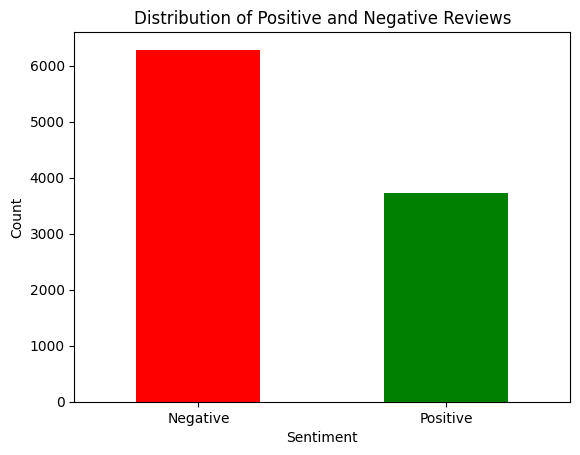

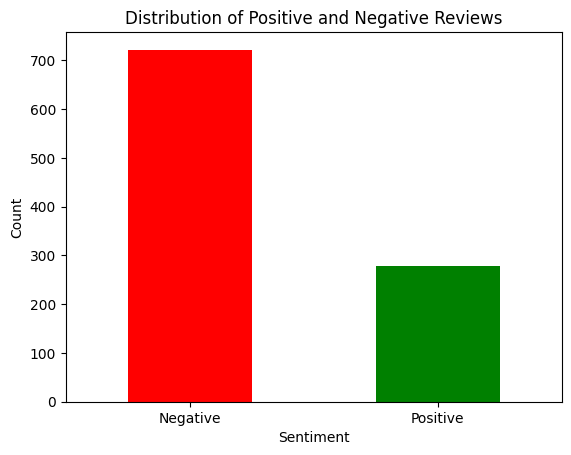

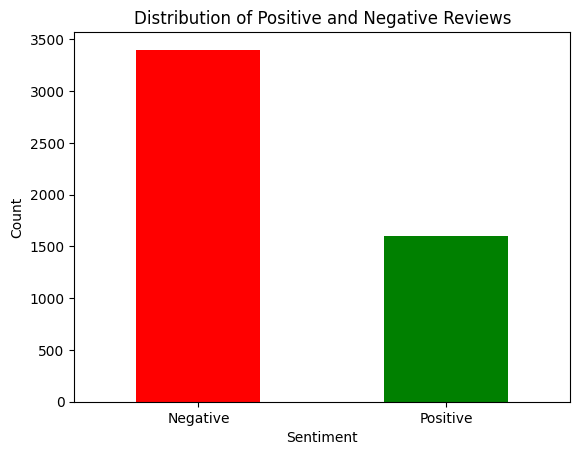

In [4]:
df['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Distribution of Positive and Negative Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

df_1k['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Distribution of Positive and Negative Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

df_5k['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Distribution of Positive and Negative Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

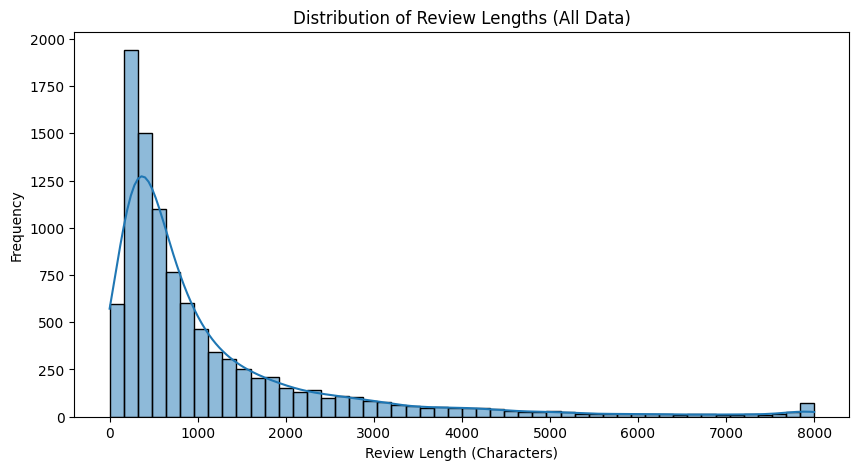

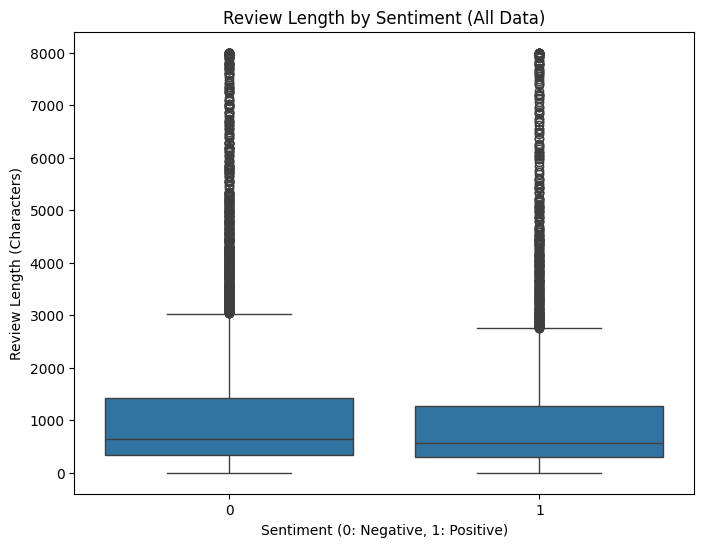

Correlation between Review Length and Sentiment (All Data): -0.03


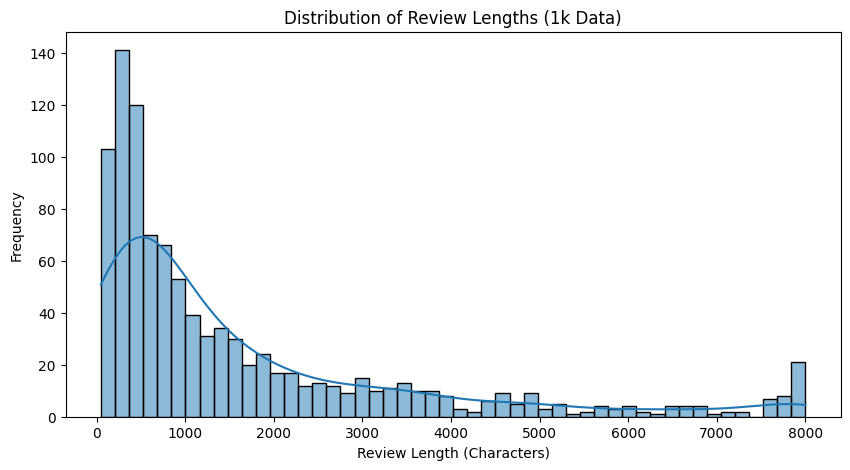

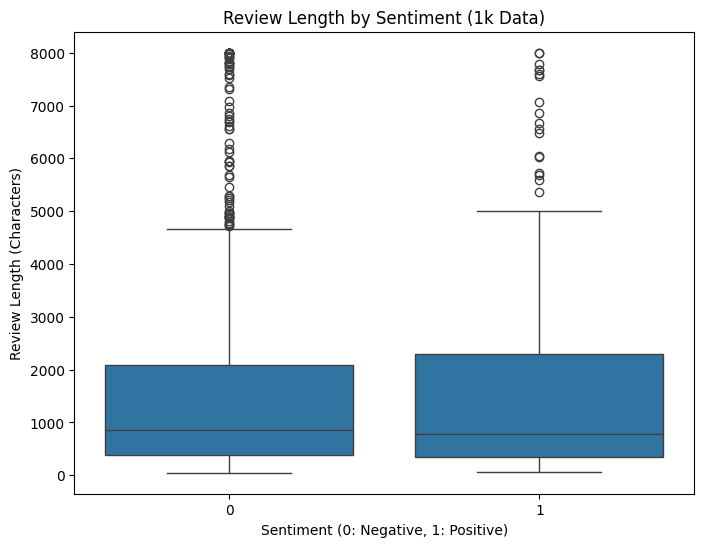

Correlation between Review Length and Sentiment (1k Data): -0.02


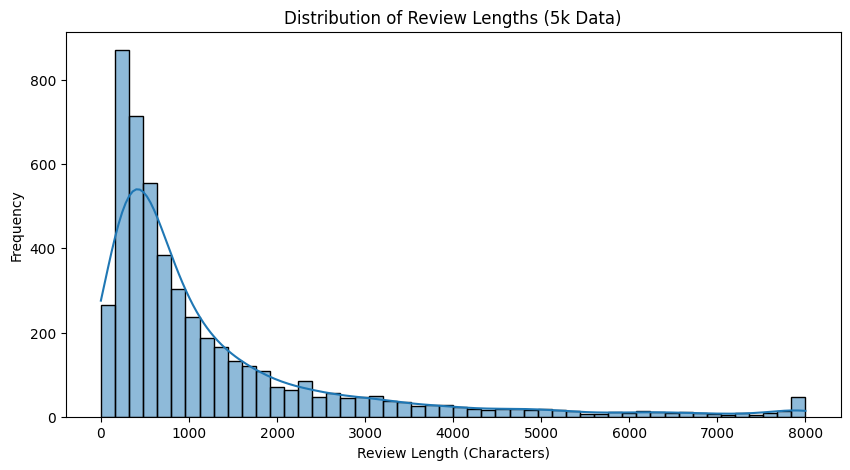

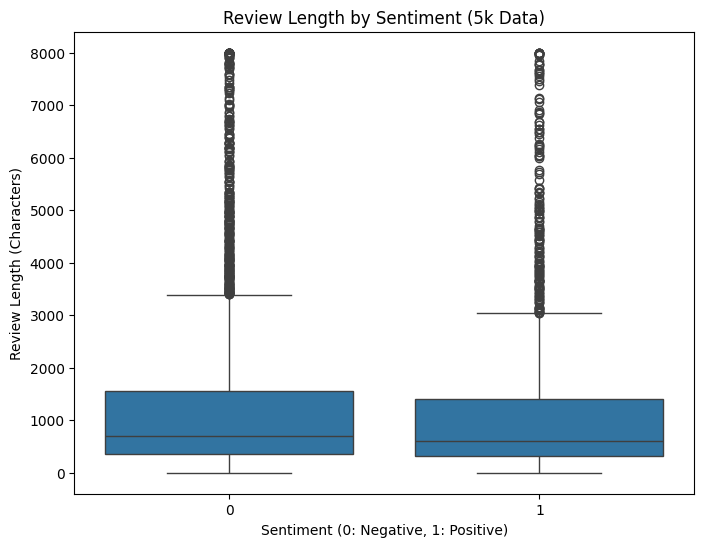

Correlation between Review Length and Sentiment (5k Data): -0.03


In [5]:
def analyze_review_length(df, dataset_name):
    df['review_length'] = df['review'].apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(df['review_length'], bins=50, kde=True)
    plt.title(f'Distribution of Review Lengths ({dataset_name})')
    plt.xlabel('Review Length (Characters)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y='review_length', data=df)
    plt.title(f'Review Length by Sentiment ({dataset_name})')
    plt.xlabel('Sentiment (0: Negative, 1: Positive)')
    plt.ylabel('Review Length (Characters)')
    plt.show()

    correlation = df['review_length'].corr(df['label'])
    print(f'Correlation between Review Length and Sentiment ({dataset_name}): {correlation:.2f}')

analyze_review_length(df, 'All Data')
analyze_review_length(df_1k, '1k Data')
analyze_review_length(df_5k, '5k Data')

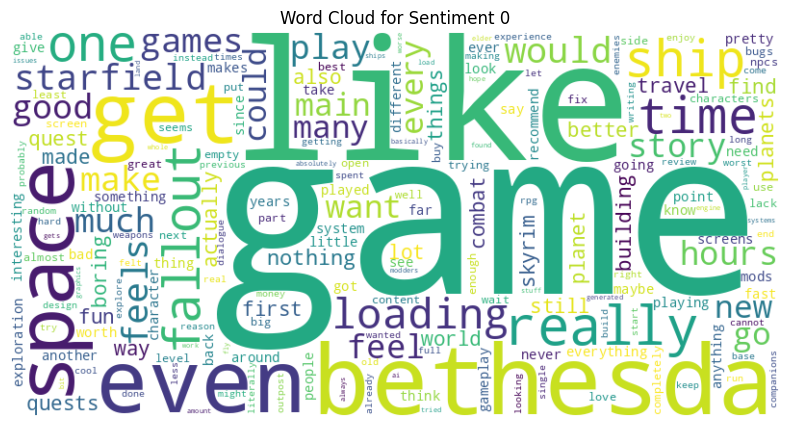

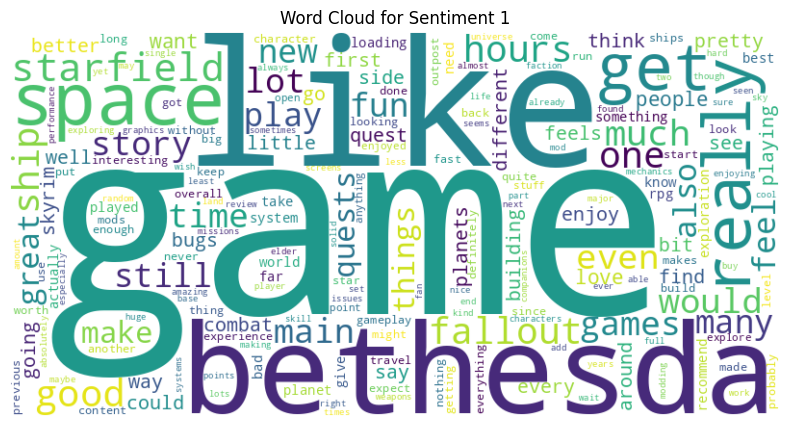

In [6]:
def analyze_word_frequency(df, sentiment):
    stop_words = set(stopwords.words('english'))
    words = []
    for review in df[df['label'] == sentiment]['review']:
        for word in review.lower().split():
            if word not in stop_words and word.isalpha():
                words.append(word)

    freq_dist = FreqDist(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Sentiment {sentiment}")
    plt.show()

analyze_word_frequency(df, 0)
analyze_word_frequency(df, 1)



In [7]:
X_1k = df_1k["review"]
y_1k = df_1k["label"]
X_train_1k, X_test_1k, y_train_1k, y_test_1k = train_test_split(
    X_1k, y_1k, test_size=0.2, random_state=42
)

vectorizer_1k = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf_1k = vectorizer_1k.fit_transform(X_train_1k)

X_test_tfidf_1k = vectorizer_1k.transform(X_test_1k)

smote = SMOTE(random_state=42)
X_train_resampled_1k, y_train_resampled_1k = smote.fit_resample(
    X_train_tfidf_1k, y_train_1k
)

nb_model_1k = MultinomialNB(alpha=1.0)
nb_model_1k.fit(X_train_resampled_1k, y_train_resampled_1k)

y_pred_nb_1k = nb_model_1k.predict(X_test_tfidf_1k)

print("Naive Bayes Classification Report (1k):")
print(
    classification_report(
        y_test_1k, y_pred_nb_1k, labels=[0, 1], target_names=["Negative", "Positive"]
    )
)

Naive Bayes Classification Report (1k):
              precision    recall  f1-score   support

    Negative       0.91      0.82      0.86       148
    Positive       0.60      0.77      0.67        52

    accuracy                           0.81       200
   macro avg       0.75      0.79      0.77       200
weighted avg       0.83      0.81      0.81       200



In [8]:
X_5k = df_5k["review"]
y_5k = df_5k["label"]

X_train_5k, X_test_5k, y_train_5k, y_test_5k = train_test_split(
    X_5k, y_5k, test_size=0.2, random_state=42, stratify=y_5k
)

vectorizer_5k = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf_5k = vectorizer_5k.fit_transform(X_train_5k)

X_test_tfidf_5k = vectorizer_5k.transform(X_test_5k)

smote = SMOTE(random_state=42)
X_train_resampled_5k, y_train_resampled_5k = smote.fit_resample(
    X_train_tfidf_5k, y_train_5k
)

nb_model_5k = MultinomialNB(alpha=1.0)
nb_model_5k.fit(X_train_resampled_5k, y_train_resampled_5k)

y_pred_nb_5k = nb_model_5k.predict(X_test_tfidf_5k)

print("Naive Bayes Classification Report (5k):")
print(classification_report(y_test_5k, y_pred_nb_5k, labels=[0, 1], target_names=["Negative", "Positive"]))

Naive Bayes Classification Report (5k):
              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90       680
    Positive       0.77      0.85      0.81       320

    accuracy                           0.87      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.87      0.87      0.87      1000



In [9]:
X = df["review"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_tfidf, y_train
)

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Classification Report (10k):")
print(classification_report(y_test, y_pred_nb, labels=[0, 1], target_names=["Negative", "Positive"]))

Naive Bayes Classification Report (10k):
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      1257
    Positive       0.83      0.86      0.85       743

    accuracy                           0.88      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [10]:
def balance_dataset(dataset):
    df = dataset.to_pandas()

    original_text = df['text'].copy()

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_tfidf = vectorizer.fit_transform(df['text'])

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_tfidf, df['label'])

    balanced_df = pd.DataFrame({'text': original_text.iloc[range(len(original_text))], 'label': y_resampled})
    balanced_dataset = Dataset.from_pandas(balanced_df)

    return balanced_dataset
train_data_1k = pd.DataFrame({"text": X_train_1k, "label": y_train_1k})
test_data_1k = pd.DataFrame({"text": X_test_1k, "label": y_test_1k})

train_dataset_1k = Dataset.from_pandas(train_data_1k)
test_dataset_1k = Dataset.from_pandas(test_data_1k)

train_dataset_1k = balance_dataset(train_dataset_1k)

tokenizer_1k = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_1k(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset_1k = train_dataset_1k.map(tokenize_function, batched=True)
test_dataset_1k = test_dataset_1k.map(tokenize_function, batched=True)

train_dataset_1k = train_dataset_1k.remove_columns(["text"])
test_dataset_1k = test_dataset_1k.remove_columns(["text"])

train_dataset_1k = train_dataset_1k.rename_column("label", "labels")
test_dataset_1k = test_dataset_1k.rename_column("label", "labels")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/1148 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [11]:
os.environ["WANDB_MODE"] = "disabled"
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer_1k = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_1k,
    eval_dataset=test_dataset_1k
)

trainer_1k.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,0.345600,0.402790
2,0.183200,0.336031
3,0.167400,0.339118


TrainOutput(global_step=432, training_loss=0.2665471362846869, metrics={'train_runtime': 180.2023, 'train_samples_per_second': 19.112, 'train_steps_per_second': 2.397, 'total_flos': 456217720971264.0, 'train_loss': 0.2665471362846869, 'epoch': 3.0})

In [12]:
test_encodings_1k = tokenizer_1k(list(X_test_1k), truncation=True, padding=True)
test_dataset_for_prediction_1k = Dataset.from_dict(test_encodings_1k)
test_dataset_for_prediction_1k = test_dataset_for_prediction_1k.add_column("labels", y_test_1k)
predictions_1k, labels_1k, _ = trainer_1k.predict(test_dataset_for_prediction_1k)
y_pred_bert_1k = np.argmax(predictions_1k, axis=1)

print("DistilBERT Classification Report (1k):")
print(classification_report(labels_1k, y_pred_bert_1k, target_names=["Negative", "Positive"]))

DistilBERT Classification Report (1k):
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.90       148
    Positive       0.72      0.75      0.74        52

    accuracy                           0.86       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.86      0.86      0.86       200



In [13]:
train_data_5k = pd.DataFrame({"text": X_train_5k, "label": y_train_5k})
test_data_5k = pd.DataFrame({"text": X_test_5k, "label": y_test_5k})

train_dataset_5k = Dataset.from_pandas(train_data_5k)
test_dataset_5k = Dataset.from_pandas(test_data_5k)

train_dataset_5k = balance_dataset(train_dataset_5k)

tokenizer_5k = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_5k(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset_5k = train_dataset_5k.map(tokenize_function, batched=True)
test_dataset_5k = test_dataset_5k.map(tokenize_function, batched=True)

train_dataset_5k = train_dataset_5k.remove_columns(["text"])
test_dataset_5k = test_dataset_5k.remove_columns(["text"])

train_dataset_5k = train_dataset_5k.rename_column("label", "labels")
test_dataset_5k = test_dataset_5k.rename_column("label", "labels")

Map:   0%|          | 0/5440 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
os.environ["WANDB_MODE"] = "disabled"
model_5k = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
training_args_5k = TrainingArguments(
    output_dir="./results_5k",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_5k",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer_5k = Trainer(
    model=model_5k,
    args=training_args_5k,
    train_dataset=train_dataset_5k,
    eval_dataset=test_dataset_5k,
)

trainer_5k.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.390500,0.347412
2,0.315500,0.385968
3,0.111700,0.448426


TrainOutput(global_step=2040, training_loss=0.20150093312612644, metrics={'train_runtime': 839.3495, 'train_samples_per_second': 19.444, 'train_steps_per_second': 2.43, 'total_flos': 2161867946065920.0, 'train_loss': 0.20150093312612644, 'epoch': 3.0})

In [15]:
test_encodings_5k = tokenizer_5k(list(X_test_5k), truncation=True, padding=True)
test_dataset_for_prediction_5k = Dataset.from_dict(test_encodings_5k)
test_dataset_for_prediction_5k = test_dataset_for_prediction_5k.add_column("labels", y_test_5k)
predictions_5k, labels_5k, _ = trainer_5k.predict(test_dataset_for_prediction_5k)
y_pred_bert_5k = np.argmax(predictions_5k, axis=1)

print("DistilBERT Classification Report (5k):")
print(classification_report(labels_5k, y_pred_bert_5k, target_names=["Negative", "Positive"]))

DistilBERT Classification Report (5k):
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.92       680
    Positive       0.85      0.78      0.81       320

    accuracy                           0.89      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.88      0.89      0.88      1000



In [16]:
train_data_10k = pd.DataFrame({"text": X_train, "label": y_train})
test_data_10k = pd.DataFrame({"text": X_test, "label": y_test})

train_dataset_10k = Dataset.from_pandas(train_data_10k)
test_dataset_10k = Dataset.from_pandas(test_data_10k)

train_dataset_10k = balance_dataset(train_dataset_10k)

tokenizer_10k = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_10k(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset_10k = train_dataset_10k.map(tokenize_function, batched=True)
test_dataset_10k = test_dataset_10k.map(tokenize_function, batched=True)

train_dataset_10k = train_dataset_10k.remove_columns(["text"])
test_dataset_10k = test_dataset_10k.remove_columns(["text"])

train_dataset_10k = train_dataset_10k.rename_column("label", "labels")
test_dataset_10k = test_dataset_10k.rename_column("label", "labels")


Map:   0%|          | 0/10052 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_10k,
    eval_dataset=test_dataset_10k
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.059400,0.348125
2,0.112700,0.312833
3,0.394900,0.347333


TrainOutput(global_step=3771, training_loss=0.19795532238150315, metrics={'train_runtime': 1561.4006, 'train_samples_per_second': 19.313, 'train_steps_per_second': 2.415, 'total_flos': 3994686873870336.0, 'train_loss': 0.19795532238150315, 'epoch': 3.0})

In [18]:
test_encodings = tokenizer_10k(list(X_test), truncation=True, padding=True)
test_dataset_for_prediction = Dataset.from_dict(test_encodings)
test_dataset_for_prediction = test_dataset_for_prediction.add_column("labels", y_test)
predictions, labels, _ = trainer.predict(test_dataset_for_prediction)
y_pred_bert = np.argmax(predictions, axis = 1)

print("DistilBERT Classification Report:")
print(classification_report(labels, y_pred_bert, target_names=["Negative", "Positive"]))

DistilBERT Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94      1257
    Positive       0.91      0.87      0.89       743

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000



In [19]:
tokenizer_1k_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function_bert(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_1k_bert(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_data_1k = pd.DataFrame({"text": X_train_1k, "label": y_train_1k})
test_data_1k = pd.DataFrame({"text": X_test_1k, "label": y_test_1k})

train_dataset_1k_bert = Dataset.from_pandas(train_data_1k)
test_dataset_1k_bert = Dataset.from_pandas(test_data_1k)

train_dataset_1k_bert = balance_dataset(train_dataset_1k_bert)
train_dataset_1k_bert = train_dataset_1k_bert.map(tokenize_function_bert, batched=True)
test_dataset_1k_bert = test_dataset_1k_bert.map(tokenize_function_bert, batched=True)

train_dataset_1k_bert = train_dataset_1k_bert.remove_columns(["text"])
test_dataset_1k_bert = test_dataset_1k_bert.remove_columns(["text"])

train_dataset_1k_bert = train_dataset_1k_bert.rename_column("label", "labels")
test_dataset_1k_bert = test_dataset_1k_bert.rename_column("label", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1148 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [20]:
os.environ["WANDB_MODE"] = "disabled"
model_1k_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
training_args_1k_bert = TrainingArguments(
    output_dir="./results_1k_bert",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_1k_bert",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer_1k_bert = Trainer(
    model=model_1k_bert,
    args=training_args_1k_bert,
    train_dataset=train_dataset_1k_bert,
    eval_dataset=test_dataset_1k_bert,
)

trainer_1k_bert.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.305700,0.395090
2,0.147000,0.330733
3,0.085200,0.367865


TrainOutput(global_step=432, training_loss=0.2354785525412471, metrics={'train_runtime': 351.0906, 'train_samples_per_second': 9.809, 'train_steps_per_second': 1.23, 'total_flos': 906154474659840.0, 'train_loss': 0.2354785525412471, 'epoch': 3.0})

In [21]:
test_encodings_1k_bert = tokenizer_1k_bert(list(X_test_1k), truncation=True, padding=True)
test_dataset_for_prediction_1k_bert = Dataset.from_dict(test_encodings_1k_bert)
test_dataset_for_prediction_1k_bert = test_dataset_for_prediction_1k_bert.add_column("labels", y_test_1k)

predictions_1k_bert, labels_1k_bert, _ = trainer_1k_bert.predict(test_dataset_for_prediction_1k_bert)

y_pred_bert_1k = np.argmax(predictions_1k_bert, axis=1)

print("BERT Classification Report (1k):")
print(classification_report(labels_1k_bert, y_pred_bert_1k, target_names=["Negative", "Positive"]))

BERT Classification Report (1k):
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.92       148
    Positive       0.75      0.77      0.76        52

    accuracy                           0.88       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.88      0.88      0.88       200



In [22]:
tokenizer_5k_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function_bert(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_5k_bert(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_data_5k = pd.DataFrame({"text": X_train_5k, "label": y_train_5k})
test_data_5k = pd.DataFrame({"text": X_test_5k, "label": y_test_5k})

train_dataset_5k_bert = Dataset.from_pandas(train_data_5k)
test_dataset_5k_bert = Dataset.from_pandas(test_data_5k)

train_dataset_5k_bert = balance_dataset(train_dataset_5k_bert)

train_dataset_5k_bert = train_dataset_5k_bert.map(tokenize_function_bert, batched=True)
test_dataset_5k_bert = test_dataset_5k_bert.map(tokenize_function_bert, batched=True)

train_dataset_5k_bert = train_dataset_5k_bert.remove_columns(["text"])
test_dataset_5k_bert = test_dataset_5k_bert.remove_columns(["text"])

train_dataset_5k_bert = train_dataset_5k_bert.rename_column("label", "labels")
test_dataset_5k_bert = test_dataset_5k_bert.rename_column("label", "labels")

Map:   0%|          | 0/5440 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [23]:
os.environ["WANDB_MODE"] = "disabled"

model_5k_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args_5k_bert = TrainingArguments(
    output_dir="./results_5k_bert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_5k_bert",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer_5k_bert = Trainer(
    model=model_5k_bert,
    args=training_args_5k_bert,
    train_dataset=train_dataset_5k_bert,
    eval_dataset=test_dataset_5k_bert,
)

trainer_5k_bert.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.221400,0.381493
2,0.236400,0.379147
3,0.132900,0.406252


TrainOutput(global_step=2040, training_loss=0.15833629989293496, metrics={'train_runtime': 1662.6819, 'train_samples_per_second': 9.815, 'train_steps_per_second': 1.227, 'total_flos': 4293972423475200.0, 'train_loss': 0.15833629989293496, 'epoch': 3.0})

In [24]:
test_encodings_5k_bert = tokenizer_5k_bert(list(X_test_5k), truncation=True, padding=True)
test_dataset_for_prediction_5k_bert = Dataset.from_dict(test_encodings_5k_bert)
test_dataset_for_prediction_5k_bert = test_dataset_for_prediction_5k_bert.add_column("labels", y_test_5k)

predictions_5k_bert, labels_5k_bert, _ = trainer_5k_bert.predict(test_dataset_for_prediction_5k_bert)
y_pred_bert_5k = np.argmax(predictions_5k_bert, axis=1)

print("BERT Classification Report (5k):")
print(classification_report(labels_5k_bert, y_pred_bert_5k, target_names=["Negative", "Positive"]))

BERT Classification Report (5k):
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94       680
    Positive       0.88      0.87      0.88       320

    accuracy                           0.92      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.92      0.92      0.92      1000



In [25]:
tokenizer_10k_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function_bert(examples):
    examples["text"] = [str(text) for text in examples["text"]]
    return tokenizer_10k_bert(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_data_10k = pd.DataFrame({"text": X_train, "label": y_train})
test_data_10k = pd.DataFrame({"text": X_test, "label": y_test})

train_dataset_10k_bert = Dataset.from_pandas(train_data_10k)
test_dataset_10k_bert = Dataset.from_pandas(test_data_10k)

train_dataset_10k_bert = balance_dataset(train_dataset_10k_bert)

train_dataset_10k_bert = train_dataset_10k_bert.map(tokenize_function_bert, batched=True)
test_dataset_10k_bert = test_dataset_10k_bert.map(tokenize_function_bert, batched=True)

train_dataset_10k_bert = train_dataset_10k_bert.remove_columns(["text"])
test_dataset_10k_bert = test_dataset_10k_bert.remove_columns(["text"])

train_dataset_10k_bert = train_dataset_10k_bert.rename_column("label", "labels")
test_dataset_10k_bert = test_dataset_10k_bert.rename_column("label", "labels")

Map:   0%|          | 0/10052 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
os.environ["WANDB_MODE"] = "disabled"
model_10k_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args_10k_bert = TrainingArguments(
    output_dir="./results_10k_bert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_10k_bert",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer_10k_bert = Trainer(
    model=model_10k_bert,
    args=training_args_10k_bert,
    train_dataset=train_dataset_10k_bert,
    eval_dataset=test_dataset_10k_bert,
)

trainer_10k_bert.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,0.081600,0.320535
2,0.261700,0.305246
3,0.128900,0.368407


TrainOutput(global_step=3771, training_loss=0.1529589401301749, metrics={'train_runtime': 3088.4569, 'train_samples_per_second': 9.764, 'train_steps_per_second': 1.221, 'total_flos': 7934376985436160.0, 'train_loss': 0.1529589401301749, 'epoch': 3.0})

In [27]:
test_encodings_10k_bert = tokenizer_10k_bert(list(X_test), truncation=True, padding=True)
test_dataset_for_prediction_10k_bert = Dataset.from_dict(test_encodings_10k_bert)
test_dataset_for_prediction_10k_bert = test_dataset_for_prediction_10k_bert.add_column("labels", y_test)

predictions_10k_bert, labels_10k_bert, _ = trainer_10k_bert.predict(test_dataset_for_prediction_10k_bert)

y_pred_bert_10k = np.argmax(predictions_10k_bert, axis=1)

print("BERT Classification Report (10k):")
print(classification_report(labels_10k_bert, y_pred_bert_10k, target_names=["Negative", "Positive"]))

BERT Classification Report (10k):
              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95      1257
    Positive       0.93      0.89      0.91       743

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.94      0.93      2000



In [28]:
nb_errors = pd.DataFrame({
    "Text": X_test,
    "True Label": y_test,
    "Predicted Label": y_pred_nb
})
nb_misclassified = nb_errors[nb_errors["True Label"] != nb_errors["Predicted Label"]]
print("Naive Bayes Misclassified Samples:")
print(nb_misclassified)

bert_errors = pd.DataFrame({
    "Text": X_test.iloc[:len(y_pred_bert)],
    "True Label": y_test.iloc[:len(y_pred_bert)],
    "Predicted Label": y_pred_bert
})

bert_misclassified = bert_errors[bert_errors["True Label"] != bert_errors["Predicted Label"]]
print("DistilBERT Misclassified Samples:")
print(bert_misclassified)

bert_10k_errors = pd.DataFrame({
    "Text": X_test,
    "True Label": y_test,
    "Predicted Label": y_pred_bert_10k
})
bert_10k_misclassified = bert_10k_errors[bert_10k_errors["True Label"] != bert_10k_errors["Predicted Label"]]
print("BERT 10k Misclassified Samples:")
print(bert_10k_misclassified)

Naive Bayes Misclassified Samples:
                                                   Text  True Label  \
7399  NPC walking speed is way slower than your runn...           1   
9765  Very disappointed, I only spent an hour in gam...           0   
9501  At the moment of this review i would say this ...           1   
409   rpg stuff is fun but the space stuff is mid at...           0   
462   [b]Short Review[/b]\n\nThe Worst Bethesda Game...           1   
...                                                 ...         ...   
6690  pretty good, only bethesda games i like in the...           1   
5518  Fallout NV came out 13 years ago and Obsidian ...           0   
9909  Main quest line is the shallowest I've seen in...           0   
1893  On one hand, this game let me build a great ma...           1   
7782  I LOVE starfield content, my favorite part of ...           1   

      Predicted Label  
7399                0  
9765                1  
9501                0  
409             

In [29]:
nb_report = classification_report(y_test, y_pred_nb, output_dict = True, target_names = ["Negative", "Positive"])

bert_report = classification_report(labels, y_pred_bert, output_dict = True, target_names = ["Negative", "Positive"])

metrics = ["Precision", "Recall", "F1-score", "accuracy"]

nb_metrics_negative = [nb_report["Negative"]["precision"], nb_report["Negative"]["recall"], nb_report["Negative"]["f1-score"]]
nb_metrics_positive = [nb_report["Positive"]["precision"], nb_report["Positive"]["recall"], nb_report["Positive"]["f1-score"]]
nb_accuracy = nb_report["accuracy"]

bert_metrics_negative = [bert_report["Negative"]["precision"], bert_report["Negative"]["recall"], bert_report["Negative"]["f1-score"]]
bert_metrics_positive = [bert_report["Positive"]["precision"], bert_report["Positive"]["recall"], bert_report["Positive"]["f1-score"]]
bert_metrics_accuracy = bert_report["accuracy"]

bert_10k_report = classification_report(labels_10k_bert, y_pred_bert_10k, output_dict=True, target_names=["Negative", "Positive"])

bert_10k_metrics_negative = [bert_10k_report["Negative"]["precision"], bert_10k_report["Negative"]["recall"], bert_10k_report["Negative"]["f1-score"]]
bert_10k_metrics_positive = [bert_10k_report["Positive"]["precision"], bert_10k_report["Positive"]["recall"], bert_10k_report["Positive"]["f1-score"]]
bert_10k_accuracy = bert_10k_report["accuracy"]

bert_1k_report = classification_report(labels_1k_bert, y_pred_bert_1k, output_dict=True, target_names=["Negative", "Positive"])
bert_5k_report = classification_report(labels_5k_bert, y_pred_bert_5k, output_dict=True, target_names=["Negative", "Positive"])
bert_10k_report = classification_report(labels_10k_bert, y_pred_bert_10k, output_dict=True, target_names=["Negative", "Positive"])

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
models = ['BERT (1k)', 'BERT (5k)', 'BERT (10k)']

negative_scores = [
    [bert_1k_report["Negative"]["precision"], bert_1k_report["Negative"]["recall"], bert_1k_report["Negative"]["f1-score"], bert_1k_report["accuracy"]],
    [bert_5k_report["Negative"]["precision"], bert_5k_report["Negative"]["recall"], bert_5k_report["Negative"]["f1-score"], bert_5k_report["accuracy"]],
    [bert_10k_report["Negative"]["precision"], bert_10k_report["Negative"]["recall"], bert_10k_report["Negative"]["f1-score"], bert_10k_report["accuracy"]]
]



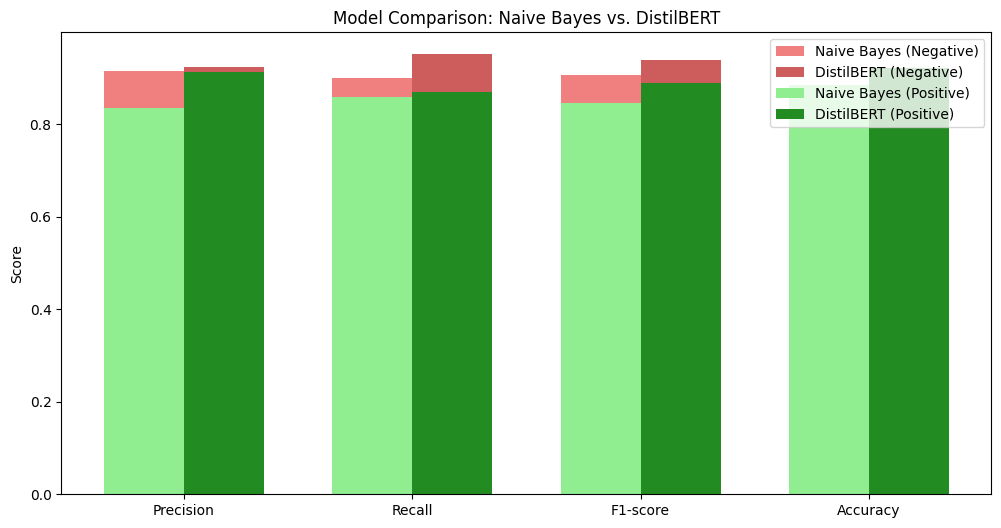

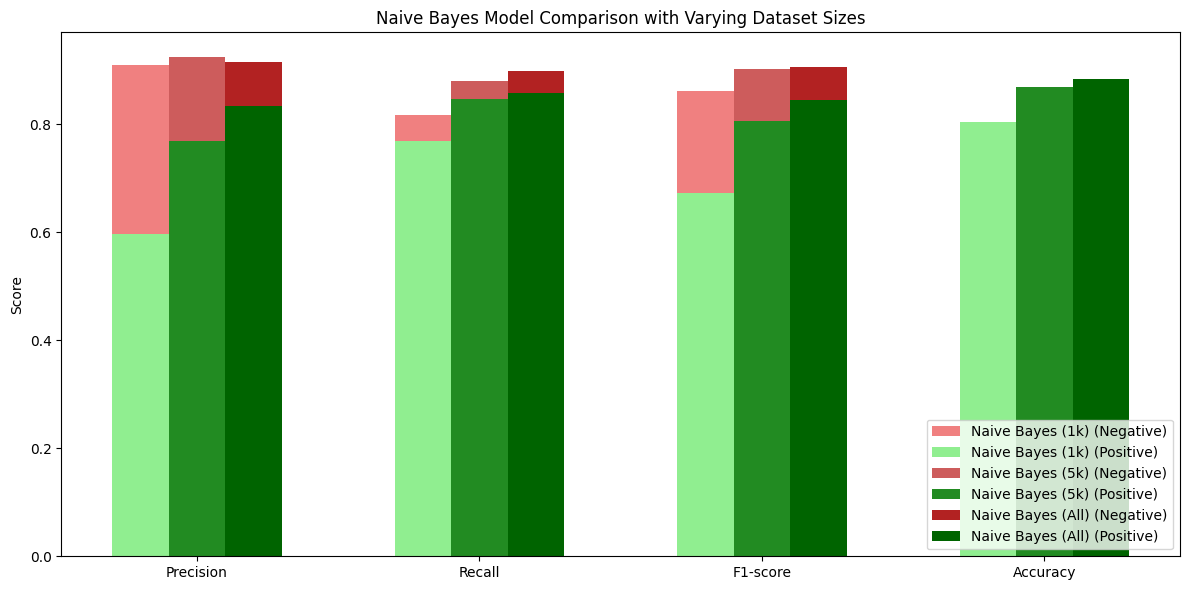

<Figure size 640x480 with 0 Axes>

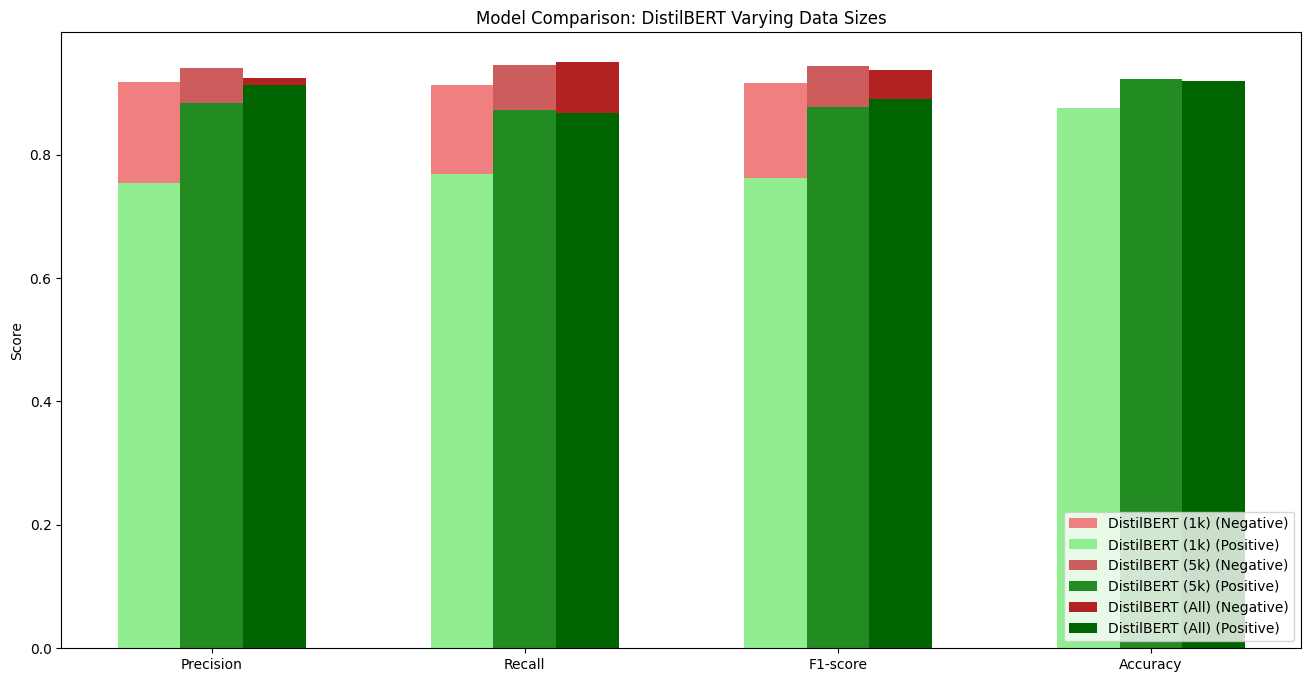

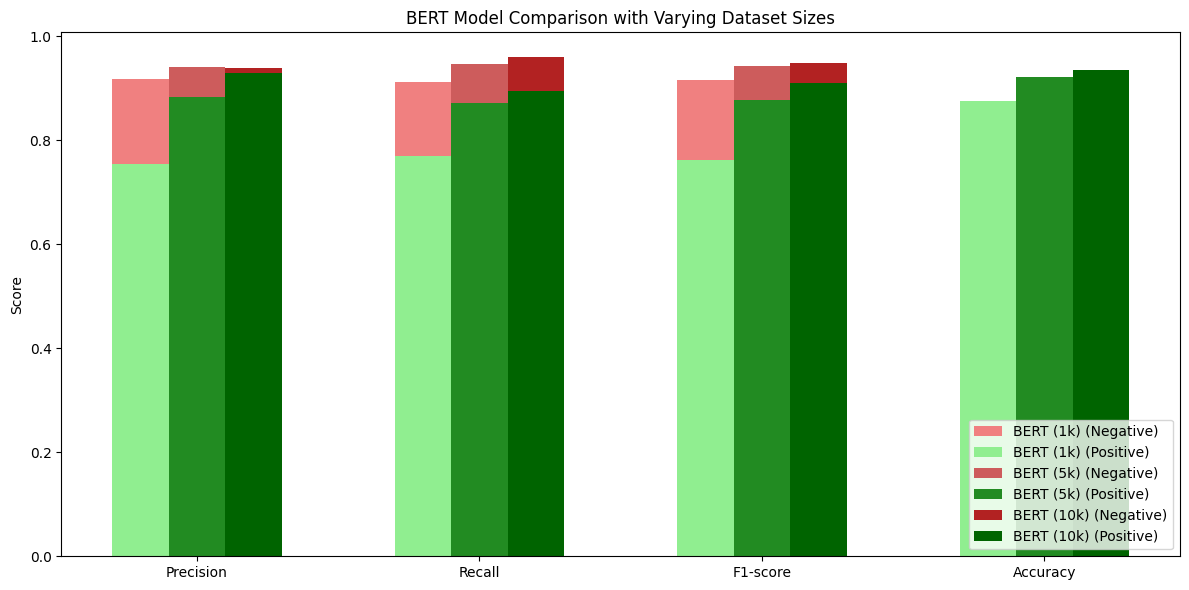

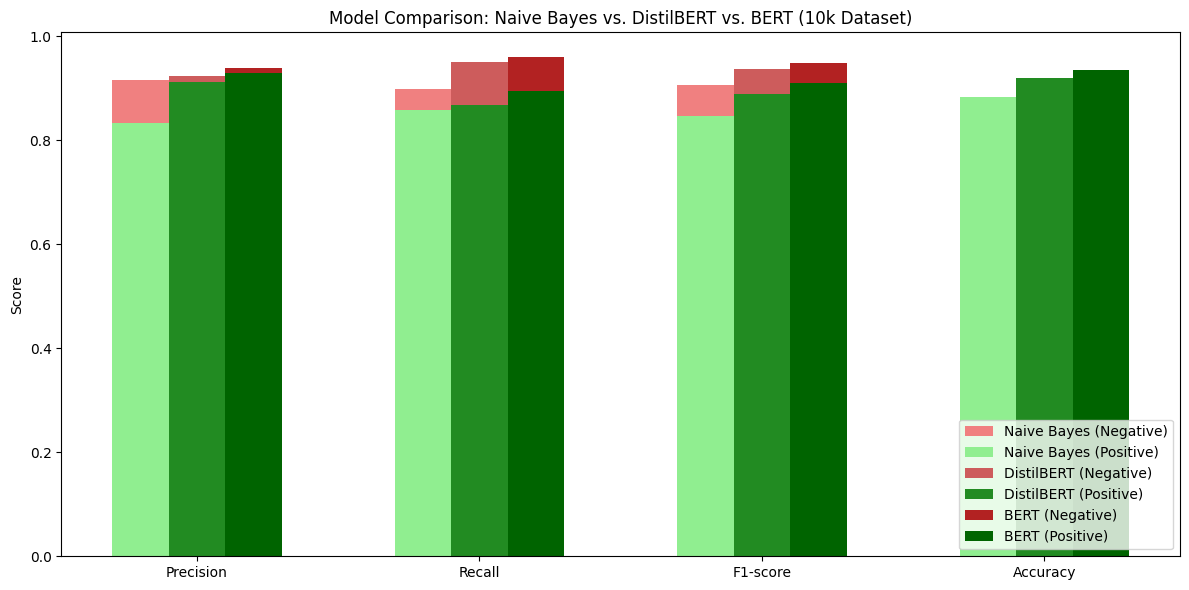

In [30]:
models = ['Naive Bayes', 'DistilBERT']
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
negative_scores = [nb_metrics_negative + [nb_accuracy], bert_metrics_negative + [bert_metrics_accuracy]]
positive_scores = [nb_metrics_positive + [nb_accuracy], bert_metrics_positive + [bert_metrics_accuracy]]


fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35

x_neg = np.arange(len(metrics))
rects1_neg = ax.bar(x_neg - width/2, negative_scores[0], width, label='Naive Bayes (Negative)', color='lightcoral')
rects2_neg = ax.bar(x_neg + width/2, negative_scores[1], width, label='DistilBERT (Negative)', color='indianred')

x_pos = np.arange(len(metrics))
rects1_pos = ax.bar(x_pos - width/2, positive_scores[0], width, label='Naive Bayes (Positive)', color='lightgreen')
rects2_pos = ax.bar(x_pos + width/2, positive_scores[1], width, label='DistilBERT (Positive)', color='forestgreen')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Naive Bayes vs. DistilBERT')
ax.set_xticks(x_neg)
ax.set_xticklabels(metrics)
ax.legend()

nb_report_1k = classification_report(y_test_1k, y_pred_nb_1k, output_dict=True, target_names=["Negative", "Positive"])
nb_report_5k = classification_report(y_test_5k, y_pred_nb_5k, output_dict=True, target_names=["Negative", "Positive"])
nb_report = classification_report(y_test, y_pred_nb, output_dict=True, target_names=["Negative", "Positive"])

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
models = ['Naive Bayes (1k)', 'Naive Bayes (5k)', 'Naive Bayes (All)']

negative_scores = [
    nb_report_1k["Negative"]["precision"], nb_report_1k["Negative"]["recall"], nb_report_1k["Negative"]["f1-score"], nb_report_1k["accuracy"],
    nb_report_5k["Negative"]["precision"], nb_report_5k["Negative"]["recall"], nb_report_5k["Negative"]["f1-score"], nb_report_5k["accuracy"],
    nb_report["Negative"]["precision"], nb_report["Negative"]["recall"], nb_report["Negative"]["f1-score"], nb_report["accuracy"]
]

positive_scores = [
    nb_report_1k["Positive"]["precision"], nb_report_1k["Positive"]["recall"], nb_report_1k["Positive"]["f1-score"], nb_report_1k["accuracy"],
    nb_report_5k["Positive"]["precision"], nb_report_5k["Positive"]["recall"], nb_report_5k["Positive"]["f1-score"], nb_report_5k["accuracy"],
    nb_report["Positive"]["precision"], nb_report["Positive"]["recall"], nb_report["Positive"]["f1-score"], nb_report["accuracy"]
]

negative_scores = np.array(negative_scores).reshape(len(models), len(metrics))
positive_scores = np.array(positive_scores).reshape(len(models), len(metrics))

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2

x = np.arange(len(metrics))
for i, model in enumerate(models):
    ax.bar(x + i * width, negative_scores[i], width, label=f'{model} (Negative)', color=['lightcoral', 'indianred', 'firebrick'][i])
    ax.bar(x + i * width, positive_scores[i], width, label=f'{model} (Positive)', color=['lightgreen', 'forestgreen', 'darkgreen'][i])

ax.set_ylabel('Score')
ax.set_title('Naive Bayes Model Comparison with Varying Dataset Sizes')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1_neg)
autolabel(rects2_neg)
autolabel(rects1_pos)
autolabel(rects2_pos)

plt.tight_layout()
plt.show()

nb_report = classification_report(y_test, y_pred_nb, output_dict=True, target_names=["Negative", "Positive"])
bert_report_1k = classification_report(labels_1k, y_pred_bert_1k, output_dict=True, target_names=["Negative", "Positive"])
bert_report_5k = classification_report(labels_5k, y_pred_bert_5k, output_dict=True, target_names=["Negative", "Positive"])
bert_report = classification_report(labels, y_pred_bert, output_dict=True, target_names=["Negative", "Positive"])


metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
models = ['DistilBERT (1k)', 'DistilBERT (5k)', 'DistilBERT (All)']

negative_scores = [
    bert_report_1k["Negative"]["precision"], bert_report_1k["Negative"]["recall"], bert_report_1k["Negative"]["f1-score"], bert_report_1k["accuracy"],
    bert_report_5k["Negative"]["precision"], bert_report_5k["Negative"]["recall"], bert_report_5k["Negative"]["f1-score"], bert_report_5k["accuracy"],
    bert_report["Negative"]["precision"], bert_report["Negative"]["recall"], bert_report["Negative"]["f1-score"], bert_report["accuracy"]
]

positive_scores = [
    bert_report_1k["Positive"]["precision"], bert_report_1k["Positive"]["recall"], bert_report_1k["Positive"]["f1-score"], bert_report_1k["accuracy"],
    bert_report_5k["Positive"]["precision"], bert_report_5k["Positive"]["recall"], bert_report_5k["Positive"]["f1-score"], bert_report_5k["accuracy"],
    bert_report["Positive"]["precision"], bert_report["Positive"]["recall"], bert_report["Positive"]["f1-score"], bert_report["accuracy"]
]


negative_scores = np.array(negative_scores).reshape(len(models), len(metrics))
positive_scores = np.array(positive_scores).reshape(len(models), len(metrics))


fig, ax = plt.subplots(figsize=(16, 8))
width = 0.2

x = np.arange(len(metrics))
for i, model in enumerate(models):
    ax.bar(x + i * width, negative_scores[i], width, label=f'{model} (Negative)', color=['lightcoral', 'indianred', 'firebrick', 'maroon'][i])
    ax.bar(x + i * width, positive_scores[i], width, label=f'{model} (Positive)', color=['lightgreen', 'forestgreen', 'darkgreen', 'seagreen'][i])

ax.set_ylabel('Score')
ax.set_title('Model Comparison: DistilBERT Varying Data Sizes')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
models = ['BERT (1k)', 'BERT (5k)', 'BERT (10k)']

negative_scores = [
    [bert_1k_report["Negative"]["precision"], bert_1k_report["Negative"]["recall"], bert_1k_report["Negative"]["f1-score"], bert_1k_report["accuracy"]],
    [bert_5k_report["Negative"]["precision"], bert_5k_report["Negative"]["recall"], bert_5k_report["Negative"]["f1-score"], bert_5k_report["accuracy"]],
    [bert_10k_report["Negative"]["precision"], bert_10k_report["Negative"]["recall"], bert_10k_report["Negative"]["f1-score"], bert_10k_report["accuracy"]]
]

positive_scores = [
    [bert_1k_report["Positive"]["precision"], bert_1k_report["Positive"]["recall"], bert_1k_report["Positive"]["f1-score"], bert_1k_report["accuracy"]],
    [bert_5k_report["Positive"]["precision"], bert_5k_report["Positive"]["recall"], bert_5k_report["Positive"]["f1-score"], bert_5k_report["accuracy"]],
    [bert_10k_report["Positive"]["precision"], bert_10k_report["Positive"]["recall"], bert_10k_report["Positive"]["f1-score"], bert_10k_report["accuracy"]]
]

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2

x = np.arange(len(metrics))
for i, model in enumerate(models):
    ax.bar(x + i * width, negative_scores[i], width, label=f'{model} (Negative)', color=['lightcoral', 'indianred', 'firebrick'][i])
    ax.bar(x + i * width, positive_scores[i], width, label=f'{model} (Positive)', color=['lightgreen', 'forestgreen', 'darkgreen'][i])

ax.set_ylabel('Score')
ax.set_title('BERT Model Comparison with Varying Dataset Sizes')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
models = ['Naive Bayes', 'DistilBERT', 'BERT']

negative_scores = [
    [nb_report["Negative"]["precision"], nb_report["Negative"]["recall"], nb_report["Negative"]["f1-score"], nb_report["accuracy"]],
    [bert_report["Negative"]["precision"], bert_report["Negative"]["recall"], bert_report["Negative"]["f1-score"], bert_report["accuracy"]],
    [bert_10k_report["Negative"]["precision"], bert_10k_report["Negative"]["recall"], bert_10k_report["Negative"]["f1-score"], bert_10k_report["accuracy"]]
]

positive_scores = [
    [nb_report["Positive"]["precision"], nb_report["Positive"]["recall"], nb_report["Positive"]["f1-score"], nb_report["accuracy"]],
    [bert_report["Positive"]["precision"], bert_report["Positive"]["recall"], bert_report["Positive"]["f1-score"], bert_report["accuracy"]],
    [bert_10k_report["Positive"]["precision"], bert_10k_report["Positive"]["recall"], bert_10k_report["Positive"]["f1-score"], bert_10k_report["accuracy"]]
]

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2

x = np.arange(len(metrics))
for i, model in enumerate(models):
    ax.bar(x + i * width, negative_scores[i], width, label=f'{model} (Negative)', color=['lightcoral', 'indianred', 'firebrick'][i])
    ax.bar(x + i * width, positive_scores[i], width, label=f'{model} (Positive)', color=['lightgreen', 'forestgreen', 'darkgreen'][i])

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Naive Bayes vs. DistilBERT vs. BERT (10k Dataset)')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()



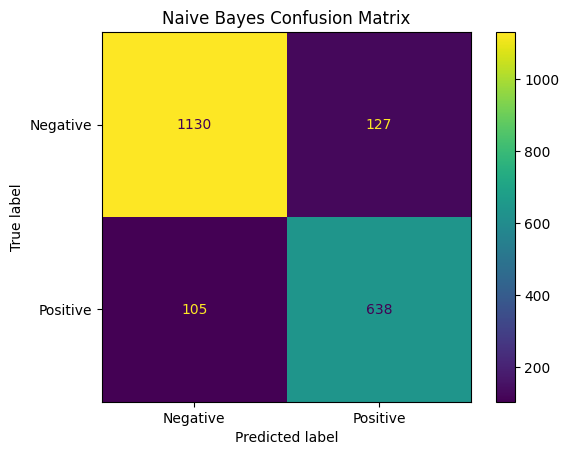

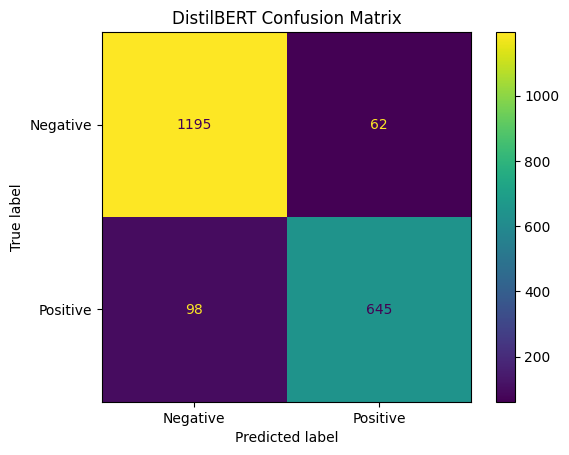

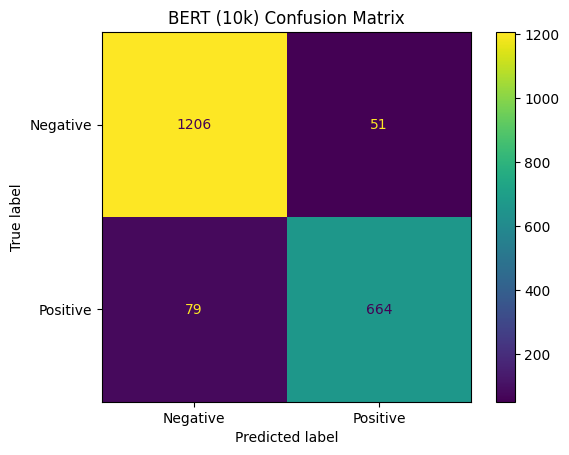

In [31]:
nb_cm = confusion_matrix(y_test, y_pred_nb)
bert_cm = confusion_matrix(labels, y_pred_bert)

disp_nb = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=["Negative", "Positive"])
disp_bert = ConfusionMatrixDisplay(confusion_matrix=bert_cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots()
disp_nb.plot(ax=ax)
ax.set_title("Naive Bayes Confusion Matrix")

fig, ax = plt.subplots()
disp_bert.plot(ax=ax)
ax.set_title("DistilBERT Confusion Matrix")

plt.show()

bert_10k_cm = confusion_matrix(labels_10k_bert, y_pred_bert_10k)

disp_bert_10k = ConfusionMatrixDisplay(confusion_matrix=bert_10k_cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots()
disp_bert_10k.plot(ax=ax)
ax.set_title("BERT (10k) Confusion Matrix")

plt.show()

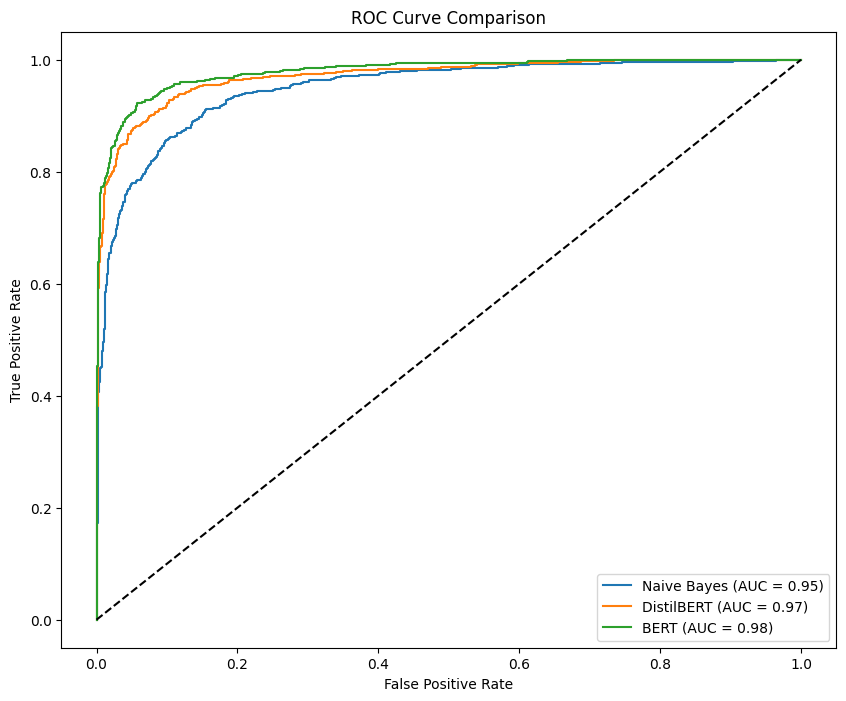

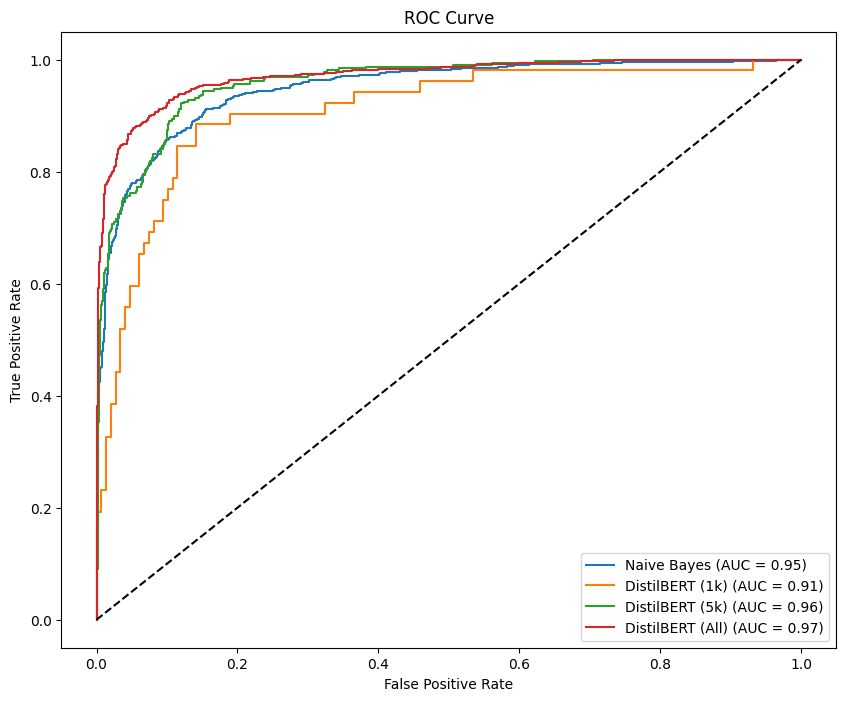

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_model.predict_proba(X_test_tfidf)[:, 1])
nb_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test_tfidf)[:, 1])

bert_fpr, bert_tpr, _ = roc_curve(labels, predictions[:, 1])
bert_auc = roc_auc_score(labels, predictions[:, 1])

bert_10k_fpr, bert_10k_tpr, _ = roc_curve(labels_10k_bert, predictions_10k_bert[:, 1])
bert_10k_auc = roc_auc_score(labels_10k_bert, predictions_10k_bert[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(nb_fpr, nb_tpr, label=f"Naive Bayes (AUC = {nb_auc:.2f})")
plt.plot(bert_fpr, bert_tpr, label=f"DistilBERT (AUC = {bert_auc:.2f})")
plt.plot(bert_10k_fpr, bert_10k_tpr, label=f"BERT (AUC = {bert_10k_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

bert_fpr_1k, bert_tpr_1k, _ = roc_curve(labels_1k, predictions_1k[:, 1])
bert_auc_1k = roc_auc_score(labels_1k, predictions_1k[:, 1])

bert_fpr_5k, bert_tpr_5k, _ = roc_curve(labels_5k, predictions_5k[:, 1])
bert_auc_5k = roc_auc_score(labels_5k, predictions_5k[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(nb_fpr, nb_tpr, label=f"Naive Bayes (AUC = {nb_auc:.2f})")
plt.plot(bert_fpr_1k, bert_tpr_1k, label=f"DistilBERT (1k) (AUC = {bert_auc_1k:.2f})")
plt.plot(bert_fpr_5k, bert_tpr_5k, label=f"DistilBERT (5k) (AUC = {bert_auc_5k:.2f})")
plt.plot(bert_fpr, bert_tpr, label=f"DistilBERT (All) (AUC = {bert_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [33]:
def get_important_ngrams(review, trainer, tokenizer, n=2, num_ngrams=10):
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    inputs = tokenizer(review, return_tensors='pt', truncation=True, max_length=512)

    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']

    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}
    outputs = trainer.model(**inputs, output_attentions=True)
    attention = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    attention_weights = attention[-1].detach().cpu().numpy()[0]
    importance_scores = np.mean(attention_weights, axis=0).sum(axis=1)

    all_ngrams = list(ngrams(tokens, n))
    ngram_scores = {}
    for ngram in all_ngrams:
        score = sum(importance_scores[tokens.index(word)] for word in ngram if word in tokens)
        ngram_scores[ngram] = score

    sorted_ngrams = sorted(ngram_scores.items(), key=lambda item: item[1], reverse=True)
    important_ngrams = [(ngram, score) for ngram, score in sorted_ngrams
                       if all(re.match(r'\b[a-zA-Z]+\b', word) and word.lower() not in stop_words for word in ngram)]

    return important_ngrams[:num_ngrams]


positive_reviews = X_test[y_test == 1]
negative_reviews = X_test[y_test == 0]

positive_important_ngrams = []
for review in positive_reviews[:100]:
    positive_important_ngrams.extend(get_important_ngrams(review, trainer_10k_bert, tokenizer_10k_bert, n=2))

negative_important_ngrams = []
for review in negative_reviews[:100]:
    negative_important_ngrams.extend(get_important_ngrams(review, trainer, tokenizer_10k_bert, n=2))

positive_ngram_scores = {}
for ngram, score in positive_important_ngrams:
    positive_ngram_scores[ngram] = positive_ngram_scores.get(ngram, 0) + score

negative_ngram_scores = {}
for ngram, score in negative_important_ngrams:
    negative_ngram_scores[ngram] = negative_ngram_scores.get(ngram, 0) + score

ngram_importance_diff = {}
for ngram in set(positive_ngram_scores) | set(negative_ngram_scores):
    ngram_importance_diff[ngram] = positive_ngram_scores.get(ngram, 0) - negative_ngram_scores.get(ngram, 0)

sorted_ngrams = sorted(ngram_importance_diff.items(), key=lambda item: item[1], reverse=True)

print("Most indicative bigrams for positive reviews:")
for ngram, score in sorted_ngrams[:10]:
    print(f"{ngram}: {score}")

print("\nMost indicative bigrams for negative reviews:")
for ngram, score in sorted_ngrams[-10:]:
    print(f"{ngram}: {score}")

positive_important_ngrams_bert = []
for review in positive_reviews[:100]:
    positive_important_ngrams_bert.extend(get_important_ngrams(review, trainer_10k_bert, tokenizer_10k_bert, n=2))

negative_important_ngrams_bert = []
for review in negative_reviews[:100]:
    negative_important_ngrams_bert.extend(get_important_ngrams(review, trainer_10k_bert, tokenizer_10k_bert, n=2))

positive_ngram_scores_bert = {}
for ngram, score in positive_important_ngrams_bert:
    positive_ngram_scores_bert[ngram] = positive_ngram_scores_bert.get(ngram, 0) + score

negative_ngram_scores_bert = {}
for ngram, score in negative_important_ngrams_bert:
    negative_ngram_scores_bert[ngram] = negative_ngram_scores_bert.get(ngram, 0) + score

ngram_importance_diff_bert = {}
for ngram in set(positive_ngram_scores_bert) | set(negative_ngram_scores_bert):
    ngram_importance_diff_bert[ngram] = positive_ngram_scores_bert.get(ngram, 0) - negative_ngram_scores_bert.get(ngram, 0)

sorted_ngrams_bert = sorted(ngram_importance_diff_bert.items(), key=lambda item: item[1], reverse=True)

print("Most indicative bigrams for positive reviews (BERT):")
for ngram, score in sorted_ngrams_bert[:10]:
    print(f"{ngram}: {score}")

print("\nMost indicative bigrams for negative reviews (BERT):")
for ngram, score in sorted_ngrams_bert[-10:]:
    print(f"{ngram}: {score}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Most indicative bigrams for positive reviews:
('feel', 'like'): 14.00000011920929
('great', 'game'): 9.999999821186066
('side', 'quest'): 8.000000178813934
('main', 'story'): 7.999999940395355
('fun', 'game'): 7.9999998807907104
('space', 'sim'): 6.0
('absolute', 'blast'): 6.0
('good', 'game'): 6.0
('much', 'better'): 6.0
('first', 'play'): 6.0

Most indicative bigrams for negative reviews:
('game', 'crashes'): -4.000000298023224
('nothing', 'new'): -5.999999821186066
('years', 'ago'): -6.0
('open', 'world'): -6.0
('game', 'feels'): -6.0
('creation', 'kit'): -6.000000059604645
('paid', 'mod'): -6.000000238418579
('game', 'lacks'): -7.999999761581421
('space', 'combat'): -8.000000059604645
('loading', 'screens'): -15.999999642372131
Most indicative bigrams for positive reviews (BERT):
('feel', 'like'): 12.000000178813934
('great', 'game'): 9.999999821186066
('side', 'quest'): 8.000000178813934
('space', 'sim'): 8.0
('fun', 'game'): 7.9999998807907104
('pretty', 'much'): 6.0
('absolute',